# BIOE C142 UGrad Final Project Checkpoint 2 - Qile Yang

Instructions: Network construction and workflow development. At this point you should have a working code that can train the network, demonstrated on small subset of the data.

In [ ]:
# notebook and python env setup

import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Checkpoint 2 Trainer Definition
___

In [ ]:
class ANITrainer:
    def __init__(self, model, batch_size, learning_rate, epoch, l2):
        self.model = model
        
        num_params = sum(item.numel() for item in model.parameters())
        print(f"{model.__class__.__name__} - Number of parameters: {num_params}")
        
        self.batch_size = batch_size
        self.optimizer = torch.optim.Adam(
            model.parameters(), lr=learning_rate, weight_decay=l2
        )
        self.epoch = epoch
    
    def train(self, train_data, val_data, early_stop=True, draw_curve=True):
        self.model.train()
        
        # init data loader
        print("Initialize training data...")
        train_data_loader = train_data.collate(self.batch_size).cache()
        train_data_len = len(train_data)
        
        # definition of loss function: MSE is a good choice! 
        loss_func = nn.MSELoss()
        
        # record epoch losses
        train_loss_list = []
        val_loss_list = []
        lowest_val_loss = np.inf
        
        for i in tqdm(range(self.epoch), leave=True):
            train_epoch_loss = 0.0
            for train_data_batch in train_data_loader:
                
                # compute energies
                true_energies = train_data_batch["energies"].to(device).float()
                
                # compute loss
                batch_loss = loss_func(
                    true_energies,
                    self.model((
                        train_data_batch['species'].to(device),
                        train_data_batch['coordinates'].to(device)
                    ))[1]
                )
                
                # do a step
                self.optimizer.zero_grad()
                batch_loss.backward()
                self.optimizer.step()
                
                batch_importance = len(train_data_batch) / train_data_len
                train_epoch_loss += batch_loss.item() * batch_importance
            
            # use the self.evaluate to get loss on the validation set 
            val_epoch_loss = self.evaluate(val_data, draw_plot=False)
            
            # append the losses
            train_loss_list.append(train_epoch_loss)
            val_loss_list.append(val_epoch_loss)
            
            if early_stop:
                if val_epoch_loss < lowest_val_loss:
                    lowest_val_loss = val_epoch_loss
                    weights = self.model.state_dict()
        
        if draw_curve:
            fig, ax = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=True)
            ax.set_yscale("log")
            # Plot train loss and validation loss
            epochs = np.arange(self.epoch)
            ax.plot(epochs, train_loss_list, label='Train')
            ax.plot(epochs, val_loss_list, label='Validation')
            ax.legend()
            ax.set_xlabel("# Batch")
            ax.set_ylabel("Loss")
        
        if early_stop:
            self.model.load_state_dict(weights)
        
        return train_loss_list, val_loss_list
    
    
    def evaluate(self, data, draw_plot=False):
        
        # init data loader
        data_loader = data.collate(self.batch_size).cache()
        data_len = len(data)
        
        # init loss function
        loss_func = nn.MSELoss()
        total_loss = 0.0
        
        if draw_plot:
            true_energies_all = []
            pred_energies_all = []
            
        with torch.no_grad():
            for batch_data in data_loader:
                
                # compute energies
                true_energies = batch_data["energies"].to(device).float()
                _, pred_energies = self.model((
                    batch_data['species'].to(device),
                    batch_data['coordinates'].to(device)
                ))

                # compute loss
                batch_loss = loss_func(true_energies, pred_energies)

                batch_importance = len(batch_data) / data_len
                total_loss += batch_loss.item() * batch_importance
                
                if draw_plot:
                    true_energies_all.append(true_energies.detach().cpu().numpy().flatten())
                    pred_energies_all.append(pred_energies.detach().cpu().numpy().flatten())

        if draw_plot:
            true_energies_all = np.concatenate(true_energies_all)
            pred_energies_all = np.concatenate(pred_energies_all)
            # Report the mean absolute error
            # The unit of energies in the dataset is hartree
            # please convert it to kcal/mol when reporting the mean absolute error
            # 1 hartree = 627.5094738898777 kcal/mol
            # MAE = mean(|true - pred|)
            hartree2kcalmol = (true_energies_all - pred_energies_all) * 627.5094738898777
            mae = np.mean(np.abs(hartree2kcalmol))
            fig, ax = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=True)
            ax.scatter(true_energies_all, pred_energies_all, label=f"MAE: {mae:.2f} kcal/mol", s=2)
            ax.set_xlabel("Ground Truth")
            ax.set_ylabel("Predicted")
            xmin, xmax = ax.get_xlim()
            ymin, ymax = ax.get_ylim()
            vmin, vmax = min(xmin, ymin), max(xmax, ymax)
            ax.set_xlim(vmin, vmax)
            ax.set_ylim(vmin, vmax)
            ax.plot([vmin, vmax], [vmin, vmax], color='red')
            ax.legend()

        return total_loss
        

### Checkpoint 1 Dataset loading

In [ ]:
import torchani
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

def init_aev_computer():
    Rcr = 5.2
    Rca = 3.5
    EtaR = torch.tensor([16], dtype=torch.float, device=device)
    ShfR = torch.tensor([
        0.900000, 1.168750, 1.437500, 1.706250, 
        1.975000, 2.243750, 2.512500, 2.781250, 
        3.050000, 3.318750, 3.587500, 3.856250, 
        4.125000, 4.393750, 4.662500, 4.931250
    ], dtype=torch.float, device=device)


    EtaA = torch.tensor([8], dtype=torch.float, device=device)
    Zeta = torch.tensor([32], dtype=torch.float, device=device)
    ShfA = torch.tensor([0.90, 1.55, 2.20, 2.85], dtype=torch.float, device=device)
    ShfZ = torch.tensor([
        0.19634954, 0.58904862, 0.9817477, 1.37444680, 
        1.76714590, 2.15984490, 2.5525440, 2.94524300
    ], dtype=torch.float, device=device)

    num_species = 4
    aev_computer = torchani.AEVComputer(
        Rcr, Rca, EtaR, ShfR, EtaA, Zeta, ShfA, ShfZ, num_species
    )
    return aev_computer

aev_computer = init_aev_computer()
aev_dim = aev_computer.aev_length

def load_ani_dataset(dspath):
    self_energies = torch.tensor([ # this was in the original code, but the variable isn't used?
        0.500607632585, -37.8302333826,
        -54.5680045287, -75.0362229210
    ], dtype=torch.float, device=device)
    energy_shifter = torchani.utils.EnergyShifter(None)
    species_order = ['H', 'C', 'N', 'O']

    dataset = torchani.data.load(dspath)
    dataset = dataset.subtract_self_energies(energy_shifter, species_order)
    dataset = dataset.species_to_indices(species_order)
    dataset = dataset.shuffle()
    return dataset

dataset = load_ani_dataset("./data/ani_gdb_s01_to_s04.h5")
train_data, val_data, test_data = dataset.split(0.8, 0.1, 0.1)

In [11]:
print(len(train_data))

691918


### Checkpoint 1 model definition

In [12]:
class AtomicNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(384, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
    
    def forward(self, x):
        return self.layers(x)

net_H = AtomicNet()
net_C = AtomicNet()
net_N = AtomicNet()
net_O = AtomicNet()

# ANI model requires a network for each atom type
# use torch.ANIModel() to compile atomic networks
ani_net = torchani.ANIModel([net_H, net_C, net_N, net_O])
model = nn.Sequential(
    aev_computer,
    ani_net
).to(device)

### Checkpoint 2 Demo Training Loop Demo

Note to grader: as the instructions clearly indicated that this checkpoint only needed to demonstrate that I have the ability to get the training loop working, I am only going to do very few iterations just to showcase the code since these operations are very computationally expensive. I showcase below how my `ANITrainer()` class definition and training and eval loops work correctly on a few epochs.

Sequential - Number of parameters: 197636
Initialize training data...


100%|██████████| 10/10 [03:06<00:00, 18.65s/it]


([3.5722315779028813e-07,
  1.5685234906626048e-07,
  1.6313046982092897e-07,
  1.6527435448466591e-07,
  1.583858397784593e-07,
  1.599639933161444e-07,
  1.5551698888527737e-07,
  1.5592780016203376e-07,
  1.5301020413163053e-07,
  1.4864302153051345e-07],
 [1.5188434039554123e-07,
  1.7545310061355053e-07,
  1.5412695955782022e-07,
  1.638054364581383e-07,
  1.7206899997189537e-07,
  1.5308493271058112e-07,
  1.5840675595412725e-07,
  1.6033045545566277e-07,
  1.5440164514996305e-07,
  1.493528560667484e-07])

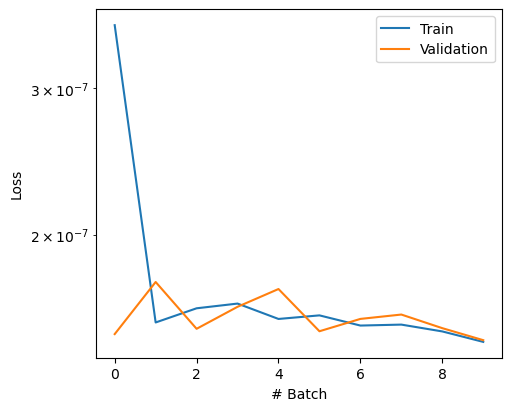

In [26]:
trainer = ANITrainer(
    model=model,
    batch_size=1024,
    learning_rate=1e-3,
    epoch=10,
    l2=1e-4
)

trainer.train(
    train_data=train_data,
    val_data=val_data,
    early_stop=True,
    draw_curve=True
)

I see that the validation loss is a little unstable but this seems to be caused by slightly high learning rate

1.3785299297635178e-07

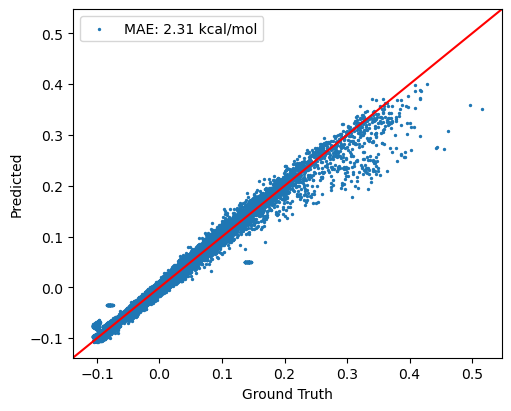

In [27]:
trainer.evaluate(test_data, draw_plot=True)

Interestingly with just 10 epochs the model is actually performing quite decently on the validation set! The correlation line actually looks pretty well fit and the MAE is only 2.31kcal/mol.